In [1]:
import sys
import os

# Add parent directory to sys.path
sys.path.append(os.path.abspath(".."))

import samplers

import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax

import importlib
importlib.reload(samplers)

from samplers import ZSchedulerLinear, AsymSampler, UnderdampedSubsetCV
from cvsampler import BiModalGaussian1D
from models import GaussianTunnel

In [2]:
dimx = 19
d = 10.
w1 = .3
w1_proposal = 0.5

sampler_z_space = BiModalGaussian1D(z1=0, z2=d, w1_proposal=w1_proposal)
energymodel = GaussianTunnel(dimx=dimx, d=d, w1=w1)
z_scheduler = ZSchedulerLinear()

sampler_asym = AsymSampler(energymodel, sampler_z_space, z_scheduler)

sampler_underdamped = UnderdampedSubsetCV(energymodel, sampler_z_space, z_scheduler)

In [3]:
z0 = jnp.array([0.,])
x0val = energymodel.mux(z0)[0]
x0 = jnp.array(dimx*[x0val,])

dt = jnp.array(0.4)
K=2000
velocity = jnp.array(d/(dt*K))

n_steps = 2000
n_chains = 20

key = jax.random.PRNGKey(42)



In [4]:
## Run the 'asym' algorithm (overdamped Langevin dynamics)
## Equivalent to the underdamped dynamics with alpha1=1.
key, (z_traj_list, x_traj, acceptance_rate, n_inter_trajectory, _, _) = sampler_asym.get_samples_parallel(x0, z0, velocity, dt, n_steps, n_chains, key)


In [5]:
## Run the overdamped dynamics (with alpha1=0 -> deterministic dynamics)

alpha1 = 0.
alpha2 = dt**2

mass = 1.
dt = np.sqrt(alpha2*mass)
gamma = 4*alpha1*mass/dt
K=50
velocity = jnp.array(d/(dt*K))
parameters = {'mass' : mass,
            'gamma' : gamma}
key = jax.random.PRNGKey(42)
key, (z_traj_list_underdamped, x_traj_list_underdamped, pacc_list_underdamped, n_inter_traj_list_underdamped, _, _) = sampler_underdamped.get_samples_parallel(x0, z0,
                                                                                                                        velocity, dt,
                                                                                                                        n_steps, n_chains,
                                                                                                                        key,vectordimension=1,
                                                                                                                        parameters=parameters)

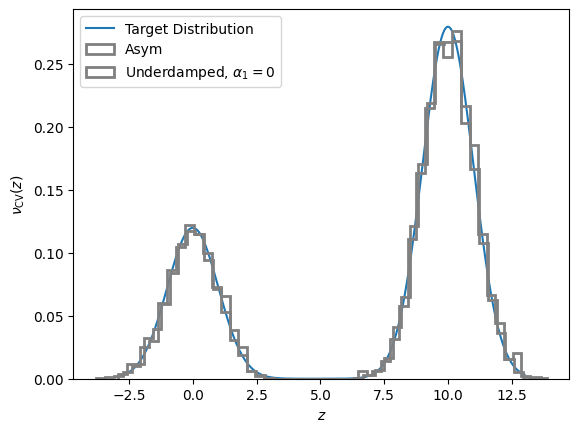

In [6]:
z_values = np.linspace(-3, 13,1000)
prob_vals = jax.vmap(energymodel.marginalpz)(jnp.array(z_values))
plt.plot(z_values, prob_vals, label="Target Distribution")
plt.hist(np.array(z_traj_list).flatten(), bins=50, density=True, label="Asym", histtype='step', linewidth=2,color='grey');
plt.hist(np.array(z_traj_list_underdamped).flatten(), bins=50, density=True, label=r"Underdamped, $\alpha_1=0$", histtype='step', linewidth=2,color='grey');


plt.xlabel("$z$")
plt.ylabel(r"$\nu_{\mathrm{CV}}(z)$")
plt.legend()